In [381]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit IPython integration
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

import pandas as pd
import glob

In [382]:
path_to_library = '../FragmentLibrary'

# list of folders for each subpocket
folders = glob.glob(path_to_library+'/*')
subpockets = [folder[-2:] for folder in folders]
subpockets

['FP', 'B2', 'AP', 'SE', 'B1', 'GA']

In [383]:
# read data

data = {}

for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]  
    file = folder+'/'+subpocket+'.sdf' 

    # read molecules
    # keep hydrogen atoms
    suppl = Chem.SDMolSupplier(file, removeHs=False)
    
    data[subpocket] = suppl
    
data

{'FP': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1e68>,
 'B2': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1ce0>,
 'AP': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1a78>,
 'SE': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1180>,
 'B1': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1ae8>,
 'GA': <rdkit.Chem.rdmolfiles.SDMolSupplier at 0x7fea0a0d1a08>}

5l4q_altB_chainA
[11*]c1c([H])nc2c(c1[H])c(N([27*])[H])c([H])n2[H]
* FP
* SE


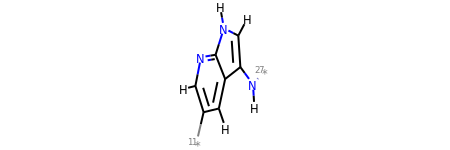

In [384]:
frag_ap = data['AP'][0]
print(frag_ap.GetProp('_Name'))
print(Chem.MolToSmiles(frag_ap))
dummyAtoms = [a for a in frag_ap.GetAtoms() if a.GetSymbol() == '*']
for atom in dummyAtoms:
    print(atom.GetSymbol(), atom.GetProp('subpocket'))
frag_ap

5l4q_altB_chainA
[25*]C(=O)c1c([H])nc([H])c([H])c1[H]
* AP


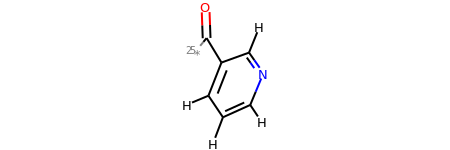

In [385]:
frag_fp = data['FP'][0]
print(frag_fp.GetProp('_Name'))
print(Chem.MolToSmiles(frag_fp))
dummyAtoms = [a for a in frag_fp.GetAtoms() if a.GetSymbol() == '*']
for atom in dummyAtoms:
    print(atom.GetSymbol(), atom.GetProp('subpocket'))
frag_fp

In [386]:
# try BRICS
from rdkit.Chem import BRICS
bricsfrags = BRICS.BRICSDecompose(frag_ap)
bricsfrags = bricsfrags.union(BRICS.BRICSDecompose(frag_fp))
bricsfrags = [Chem.MolFromSmiles(frag) for frag in bricsfrags]
ms = BRICS.BRICSBuild(bricsfrags, onlyCompleteMols=False, maxDepth=1)
results = [m for m in ms]
# outputs ALL possible combinations ...
#Draw.MolsToGridImage(results, molsPerRow=6)

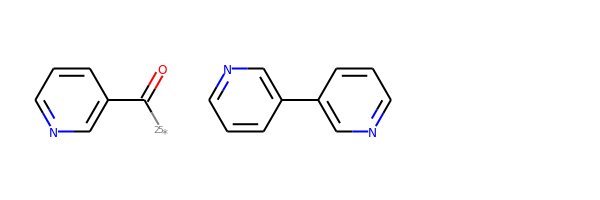

In [387]:
bricsfrags = BRICS.BRICSDecompose(frag_fp)
bricsfrags = [Chem.MolFromSmiles(frag) for frag in bricsfrags]
ms = BRICS.BRICSBuild(bricsfrags, onlyCompleteMols=False)
results = [m for m in ms]
Draw.MolsToGridImage(results)

Substructure replacement:

[11*]c1c([H])nc2c(c1[H])c(N([27*])[H])c([H])n2[H] [25*]C(=O)c1c([H])nc([H])c([H])c1[H]
[11*]c1c([H])nc2c(c1[H])c(N([H])C(=O)c1c([H])nc([H])c([H])c1[H])c([H])n2[H]


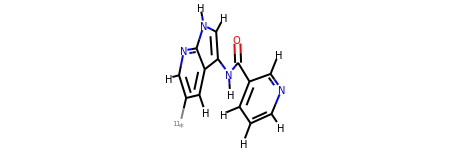

In [388]:
# combine AP and FP fragments

print(Chem.MolToSmiles(frag_ap), Chem.MolToSmiles(frag_fp))

# find atom in AP fragment where we want to reconnect
dummyAtoms = [a for a in frag_ap.GetAtoms() if a.GetSymbol() == '*']

# --- iterate over dummy atoms

dummy = [a for a in dummyAtoms if a.GetProp('subpocket') == 'FP'][0]

# dummy atom (could there be more than 1?)
dummy = Chem.MolFromSmiles(dummy.GetSmarts())

repl = Chem.DeleteSubstructs(frag_fp, Chem.MolFromSmiles('[25*]'))

mol = Chem.ReplaceSubstructs(frag_ap, dummy, repl)[0]
print(Chem.MolToSmiles(mol))
#Chem.SanitizeMol(mol)
mol

Add bond between atoms:

In [390]:
# combine AP and FP fragments

#AllChem.Compute2DCoords(frag_ap)
#AllChem.Compute2DCoords(frag_ga)

mol = Chem.CombineMols(frag_ap, frag_fp)

# find dummy atoms
dummyAtoms = [a for a in combo.GetAtoms() if a.GetSymbol() == '*']
atom1 = [a for a in dummyAtoms if a.GetProp('subpocket') == 'FP'][0].GetNeighbors()[0].GetIdx()
atom2 = [a for a in dummyAtoms if a.GetProp('subpocket') == 'AP'][0].GetNeighbors()[0].GetIdx()

edcombo = Chem.EditableMol(mol)

edcombo.AddBond(atom1, atom2,order=Chem.rdchem.BondType.SINGLE)

mol = edcombo.GetMol()
for dummy in [Chem.MolFromSmiles(dummy.GetSmarts()) for dummy in dummyAtoms]:
    mol = Chem.DeleteSubstructs(mol, dummy)
Chem.SanitizeMol(mol)
mol

RuntimeError: Pre-condition Violation
	bond already exists
	Violation occurred on line 301 in file Code/GraphMol/RWMol.cpp
	Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
	RDKIT: 2019.03.1
	BOOST: 1_68


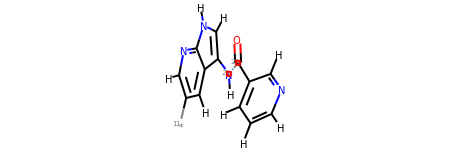

In [391]:
mol = Chem.CombineMols(frag_ap, frag_fp)
Chem.SanitizeMol(mol)
mol

5l4q_altB_chainA
[12*]c1c([H])c([H])c(C#N)c([H])c1[H]
* AP


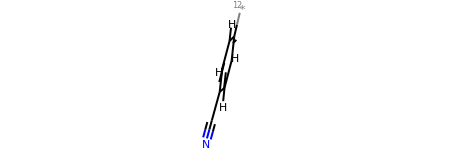

In [392]:
frag_se = data['SE'][0]
print(frag_se.GetProp('_Name'))
print(Chem.MolToSmiles(frag_se))
dummyAtoms = [a for a in frag_se.GetAtoms() if a.GetSymbol() == '*']
for atom in dummyAtoms:
    print(atom.GetSymbol(), atom.GetProp('subpocket'))
frag_se

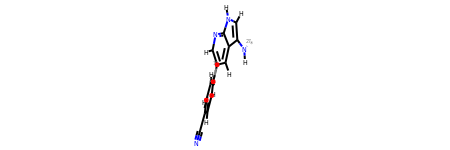

In [393]:
mol = Chem.CombineMols(frag_ap, frag_se)
Chem.SanitizeMol(mol)
mol

Combine NEW fragments:

5te0_chainA
[2*]=C1C(=O)N([H])c2c([H])c([20*])c([H])c([H])c21
* GA
* FP


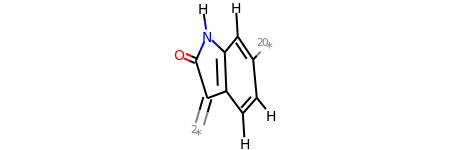

In [394]:
frag_ap = data['AP'][1]
print(frag_ap.GetProp('_Name'))
print(Chem.MolToSmiles(frag_ap))
dummyAtoms = [a for a in frag_ap.GetAtoms() if a.GetSymbol() == '*']
for atom in dummyAtoms:
    print(atom.GetSymbol(), atom.GetProp('subpocket'))
frag_ap

2jdr_chainA
[13*]c1c([H])nc([H])c([24*])c1[H]
* FP
* AP


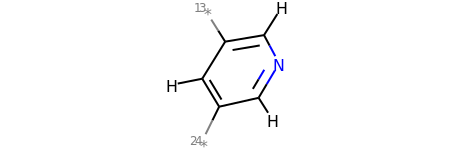

In [395]:
frag_ga = data['GA'][9]
print(frag_ga.GetProp('_Name'))
print(Chem.MolToSmiles(frag_ga))
dummyAtoms = [a for a in frag_ga.GetAtoms() if a.GetSymbol() == '*']
for atom in dummyAtoms:
    print(atom.GetSymbol(), atom.GetProp('subpocket'))
frag_ga

[2*]=C1C(=O)N([H])c2c([H])c([20*])c([H])c([H])c21
[20*]
[13*]c1c([H])nc([H])c([24*])c1[H]
[13*]
[2*]=C1C(=O)N([H])c2c([H])c(-c3c([H])nc([H])c([24*])c3[H])c([H])c([H])c21


RDKit ERROR: [14:58:07] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 301 in file /home/conda/feedstock_root/build_artifacts/rdkit_1555007059585/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:58:26] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 301 in file /home/conda/feedstock_root/build_artifacts/rdkit_1555007059585/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [14:58:36] UFFTYPER: Unrecognized atom type: *_ (14)
RDKit ERROR: [14:58:36] UFFTYPER: Unrecognized atom type: *_ (24)


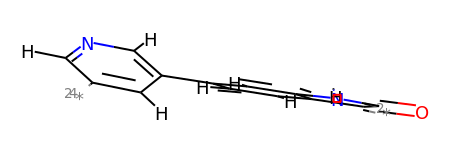

In [396]:
# combine AP and GA fragments

#AllChem.Compute2DCoords(frag_ap)
#AllChem.Compute2DCoords(frag_ga)

print(Chem.MolToSmiles(frag_ap))

# find atom in AP fragment where we want to reconnect
dummyAtoms = [a for a in frag_ap.GetAtoms() if a.GetSymbol() == '*']
dummy = [a for a in dummyAtoms if a.GetProp('subpocket') == 'GA'][0]
print(dummy.GetSmarts())
# dummy atom 
dummy = Chem.MolFromSmiles(dummy.GetSmarts())

print(Chem.MolToSmiles(frag_ga))
# find atom in GA fragment where we want to reconnect
dummyAtoms = [a for a in frag_ga.GetAtoms() if a.GetSymbol() == '*']
dummy_ga = [a for a in dummyAtoms if a.GetProp('subpocket') == 'AP'][0]
print(dummy_ga.GetSmarts())
repl = Chem.DeleteSubstructs(frag_ga, Chem.MolFromSmiles(dummy_ga.GetSmarts()))
# repl = frag_ga

mol = Chem.ReplaceSubstructs(frag_ap, dummy, repl)[0]
print(Chem.MolToSmiles(mol))
Chem.SanitizeMol(mol)
AllChem.EmbedMolecule(mol)
mol

## WORKING SOLUTION:

http://asteeves.github.io/blog/2015/01/14/editing-in-rdkit/

5te0_chainA
2jdr_chainA
SINGLE SINGLE


RDKit ERROR: [14:58:36] UFFTYPER: Unrecognized atom type: *_ (14)
RDKit ERROR: [14:58:36] UFFTYPER: Unrecognized atom type: *_ (24)


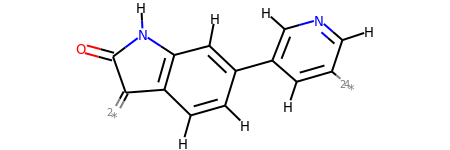

In [397]:
# combine AP and GA fragments

print(frag_ap.GetProp('_Name'))
print(frag_ga.GetProp('_Name'))

AllChem.Compute2DCoords(frag_ap)
AllChem.Compute2DCoords(frag_ga)

combo = Chem.CombineMols(frag_ap, frag_ga)

# find dummy atoms
dummyAtoms = [a for a in combo.GetAtoms() if a.GetSymbol() == '*']

dummyAtom1 = [a for a in dummyAtoms if a.GetProp('subpocket') == 'GA'][0]
dummyAtom2 = [a for a in dummyAtoms if a.GetProp('subpocket') == 'AP'][0]

atom1 = dummyAtom1.GetNeighbors()[0].GetIdx()
atom2 = dummyAtom2.GetNeighbors()[0].GetIdx()

bondType1 = combo.GetBondBetweenAtoms(dummyAtom1.GetIdx(), atom1).GetBondType()
bondType2 = combo.GetBondBetweenAtoms(dummyAtom2.GetIdx(), atom2).GetBondType()

print(bondType1, bondType2)

edcombo = Chem.EditableMol(combo)

edcombo.AddBond(atom1, atom2, order=bondType1)

# create molecule
back = edcombo.GetMol()
# remove dummy atoms
back = Chem.DeleteSubstructs(back, Chem.MolFromSmiles(dummyAtom1.GetSmarts()))
back = Chem.DeleteSubstructs(back, Chem.MolFromSmiles(dummyAtom2.GetSmarts()))

#Chem.SanitizeMol(back)
AllChem.EmbedMolecule(back, randomSeed=1, maxAttempts=0)
back

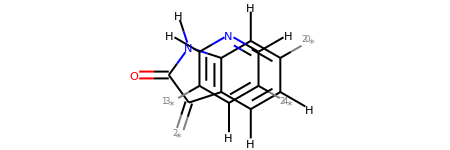

In [398]:
AllChem.Compute2DCoords(frag_ap)
AllChem.Compute2DCoords(frag_ga)
Chem.CombineMols(frag_ap, frag_ga)

Simple example:

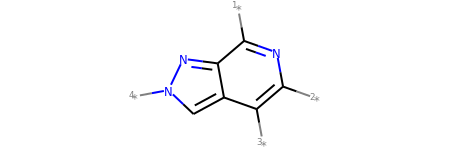

In [399]:
#core molecule
#m=Chem.SDMolSupplier('../testseesar-export/core_R4.sdf')[0]
core = Chem.MolFromSmiles('[H]C1=C2C(=NN1[4*])C([1*])=NC([2*])=C2[3*]')
core.SetProp("_Name","core")
core

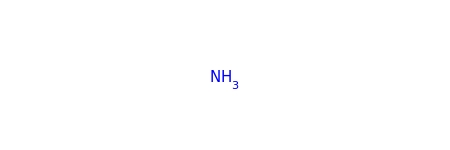

In [400]:
R1 = Chem.MolFromSmiles('N')
R1

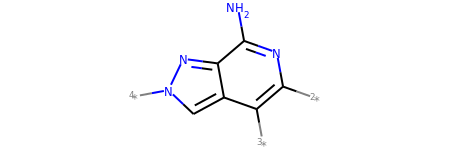

In [401]:
rms = AllChem.ReplaceSubstructs(core, Chem.MolFromSmiles('[1*]'), R1)[0]
Chem.SanitizeMol(rms)
rms